# Flare Peak Detection Machine Learning Model
This file will contain our data preprocessing, machine learning model set up, and model testing to detect flare peaks. 
 

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
path = "../data/fullSet.csv"

full_set = pd.read_csv(path, dtype={'status': str})
full_set.head()

,time,xrsa_flux,xrsb_flux,status
0,2017-02-07 00:00:00,2.949822e-08,7.072423e-08,NaN
1,2017-02-07 00:01:00,2.716477e-08,6.869706e-08,NaN
2,2017-02-07 00:02:00,2.996076e-08,6.933664e-08,NaN
3,2017-02-07 00:03:00,3.124979e-08,6.796333e-08,NaN
4,2017-02-07 00:04:00,3.095799e-08,6.928261e-08,NaN


In [26]:
full_set.shape[0]

6040249

In [27]:
# full_set['peak'] = np.where(full_set['status'] == 'EVENT_PEAK', 1, 0)
in_event = False
event_label = 0
labels = []

for status in full_set['status']:
    if status == 'EVENT_START':
        in_event = True
        event_label = 1
    elif status == 'EVENT_END':
        in_event = False
        event_label = 0
    labels.append(event_label)

full_set['flare'] = labels

full_set.head(10000)  

,time,xrsa_flux,xrsb_flux,status,flare
0,2017-02-07 00:00:00,2.949822e-08,7.072423e-08,NaN,0
1,2017-02-07 00:01:00,2.716477e-08,6.869706e-08,NaN,0
2,2017-02-07 00:02:00,2.996076e-08,6.933664e-08,NaN,0
3,2017-02-07 00:03:00,3.124979e-08,6.796333e-08,NaN,0
4,2017-02-07 00:04:00,3.095799e-08,6.928261e-08,NaN,0
...,...,...,...,...,...
9995,2017-02-14 19:56:00,4.130439e-09,3.169877e-08,NaN,0
9996,2017-02-14 19:57:00,3.370558e-09,3.293717e-08,NaN,0
9997,2017-02-14 19:58:00,4.871447e-09,3.275998e-08,NaN,0
9998,2017-02-14 19:59:00,4.171957e-09,3.249245e-08,NaN,0


In [28]:
# percentage of unique rows and duplicate rows with respect to "time" column
# roughly 43% of the rows have a repeated time value
p = (full_set['time'].nunique() / full_set.shape[0] ) * 100
print(p, 100-p)

56.879724660357546 43.120275339642454


In [29]:
def remove_zeroed_copies(df):
    '''
    Separates rows based on flare status, into zero flares and one flares
    Removes duplicate zero flares by keeping the first occurence of the row
    Merges zero flares and one flares back together 

    
    *** This removes any duplicate rows in the zero flares df, there may still be dupliate rows in the one flares df ***

        removing duplicate rows within one flares will have to be handled more carefully because these are sequences of rows that
        are associated to actual flares so removing duplication here could result in the loss of a row that contain 
        event_start, event_peak, or event_end status
    
    Parameters:

    Input:
        df: dataframe with 'flare' column

    Output:
        df: dataframe with no duplicate rows that have flare status 0 
    '''

    df_zero_flares = df[df['flare'] == 0]                                           # get rows with flare status 0, zero_flares
    df_one_flares = df[df['flare'] == 1]                                            # get rows with flare status 1, one_flares
    df_zero_flares = df_zero_flares.drop_duplicates(subset='time', keep='first')    # remove duplicate rows in zero flares
    df = pd.concat([df_zero_flares, df_one_flares])                                 # concatenate the two dataframes, df
    df.sort_values(by=['time'], inplace=True)                                       # sort df by time
    return df
    
full_set = remove_zeroed_copies(full_set)
full_set.head()

,time,xrsa_flux,xrsb_flux,status,flare
0,2017-02-07 00:00:00,2.949822e-08,7.072423e-08,NaN,0
1,2017-02-07 00:01:00,2.716477e-08,6.869706e-08,NaN,0
2,2017-02-07 00:02:00,2.996076e-08,6.933664e-08,NaN,0
3,2017-02-07 00:03:00,3.124979e-08,6.796333e-08,NaN,0
4,2017-02-07 00:04:00,3.095799e-08,6.928261e-08,NaN,0


In [30]:
# percentage of unique rows and duplicate rows with respect to "time" column
p = (full_set['time'].nunique() / full_set.shape[0] ) * 100
print(p, 100-p)

94.2818551561738 5.718144843826195


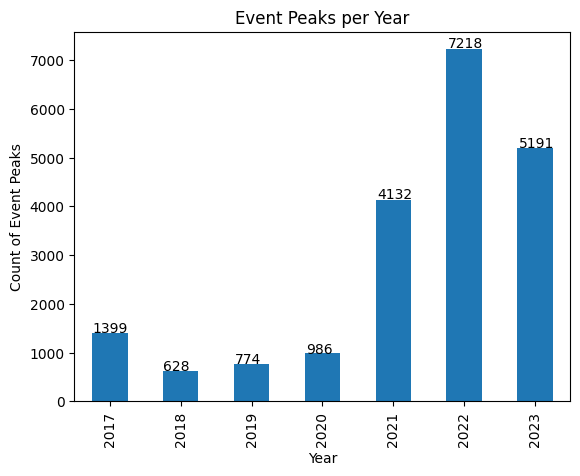

In [31]:
# plot peaks per year using peaks dataframe with counts of event peaks per year
peaks = full_set[['time', 'status']]
peaks = peaks[peaks['status'] == 'EVENT_PEAK']
peaks['year'] = pd.to_datetime(peaks['time']).dt.year
peaks_per_year = peaks.groupby('year')['status'].count()

ax = peaks_per_year.plot(kind='bar', legend=False)
ax.set_title('Event Peaks per Year')
ax.set_xlabel('Year')
ax.set_ylabel('Count of Event Peaks')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()

In [32]:
full_set.shape[0]

3644049